# Обучение ResNet18 на разных типах входных данных

## Импорт библиотек и написанных алгоритмов

In [1]:
# Стандартные библиотеки для работы с данными:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets,models,layers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

# Библиотеки для построения архитектуры ResNet18
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

# Библиотеки для формирования наборов данных:
import sys
import os
from importlib import reload

In [2]:
# Подгружаем пути к директориям с нашими алгоритмами:
cur_dir = os.getcwd()
dataset_path = os.path.join(cur_dir, "../Dataset")
wavelets_path = os.path.join(cur_dir, "../Wavelet")
script_path = os.path.join(cur_dir, "../Scripts")
print(script_path)
print(wavelets_path)
sys.path.append(dataset_path)
sys.path.append(wavelets_path)
sys.path.append(script_path)

C:\Users\F2PC\ЭКГшные приколдесы\RemoteMonitoring\Neural network\../Scripts
C:\Users\F2PC\ЭКГшные приколдесы\RemoteMonitoring\Neural network\../Wavelet


In [3]:
# Подгружаем алгоритмы для подготовки данных:
import ECGsignal as ecg # Алгоритмы для формирования датасета и цельного изображения графиков 12 отведений ЭКГ
reload(ecg) # Это для отображения изменений в файле без прерывания ядра
import VECG as vecg # Алгоритмы для формирования векторного представления кардиоциклов
reload(vecg)
import CWT as wt # Алгоритмы для вейвлет преобразования графиков ЭКГ
reload(wt)

<module 'CWT' from 'C:\\Users\\F2PC\\ЭКГшные приколдесы\\RemoteMonitoring\\Neural network\\../Wavelet\\CWT.py'>

## Подготовка данных

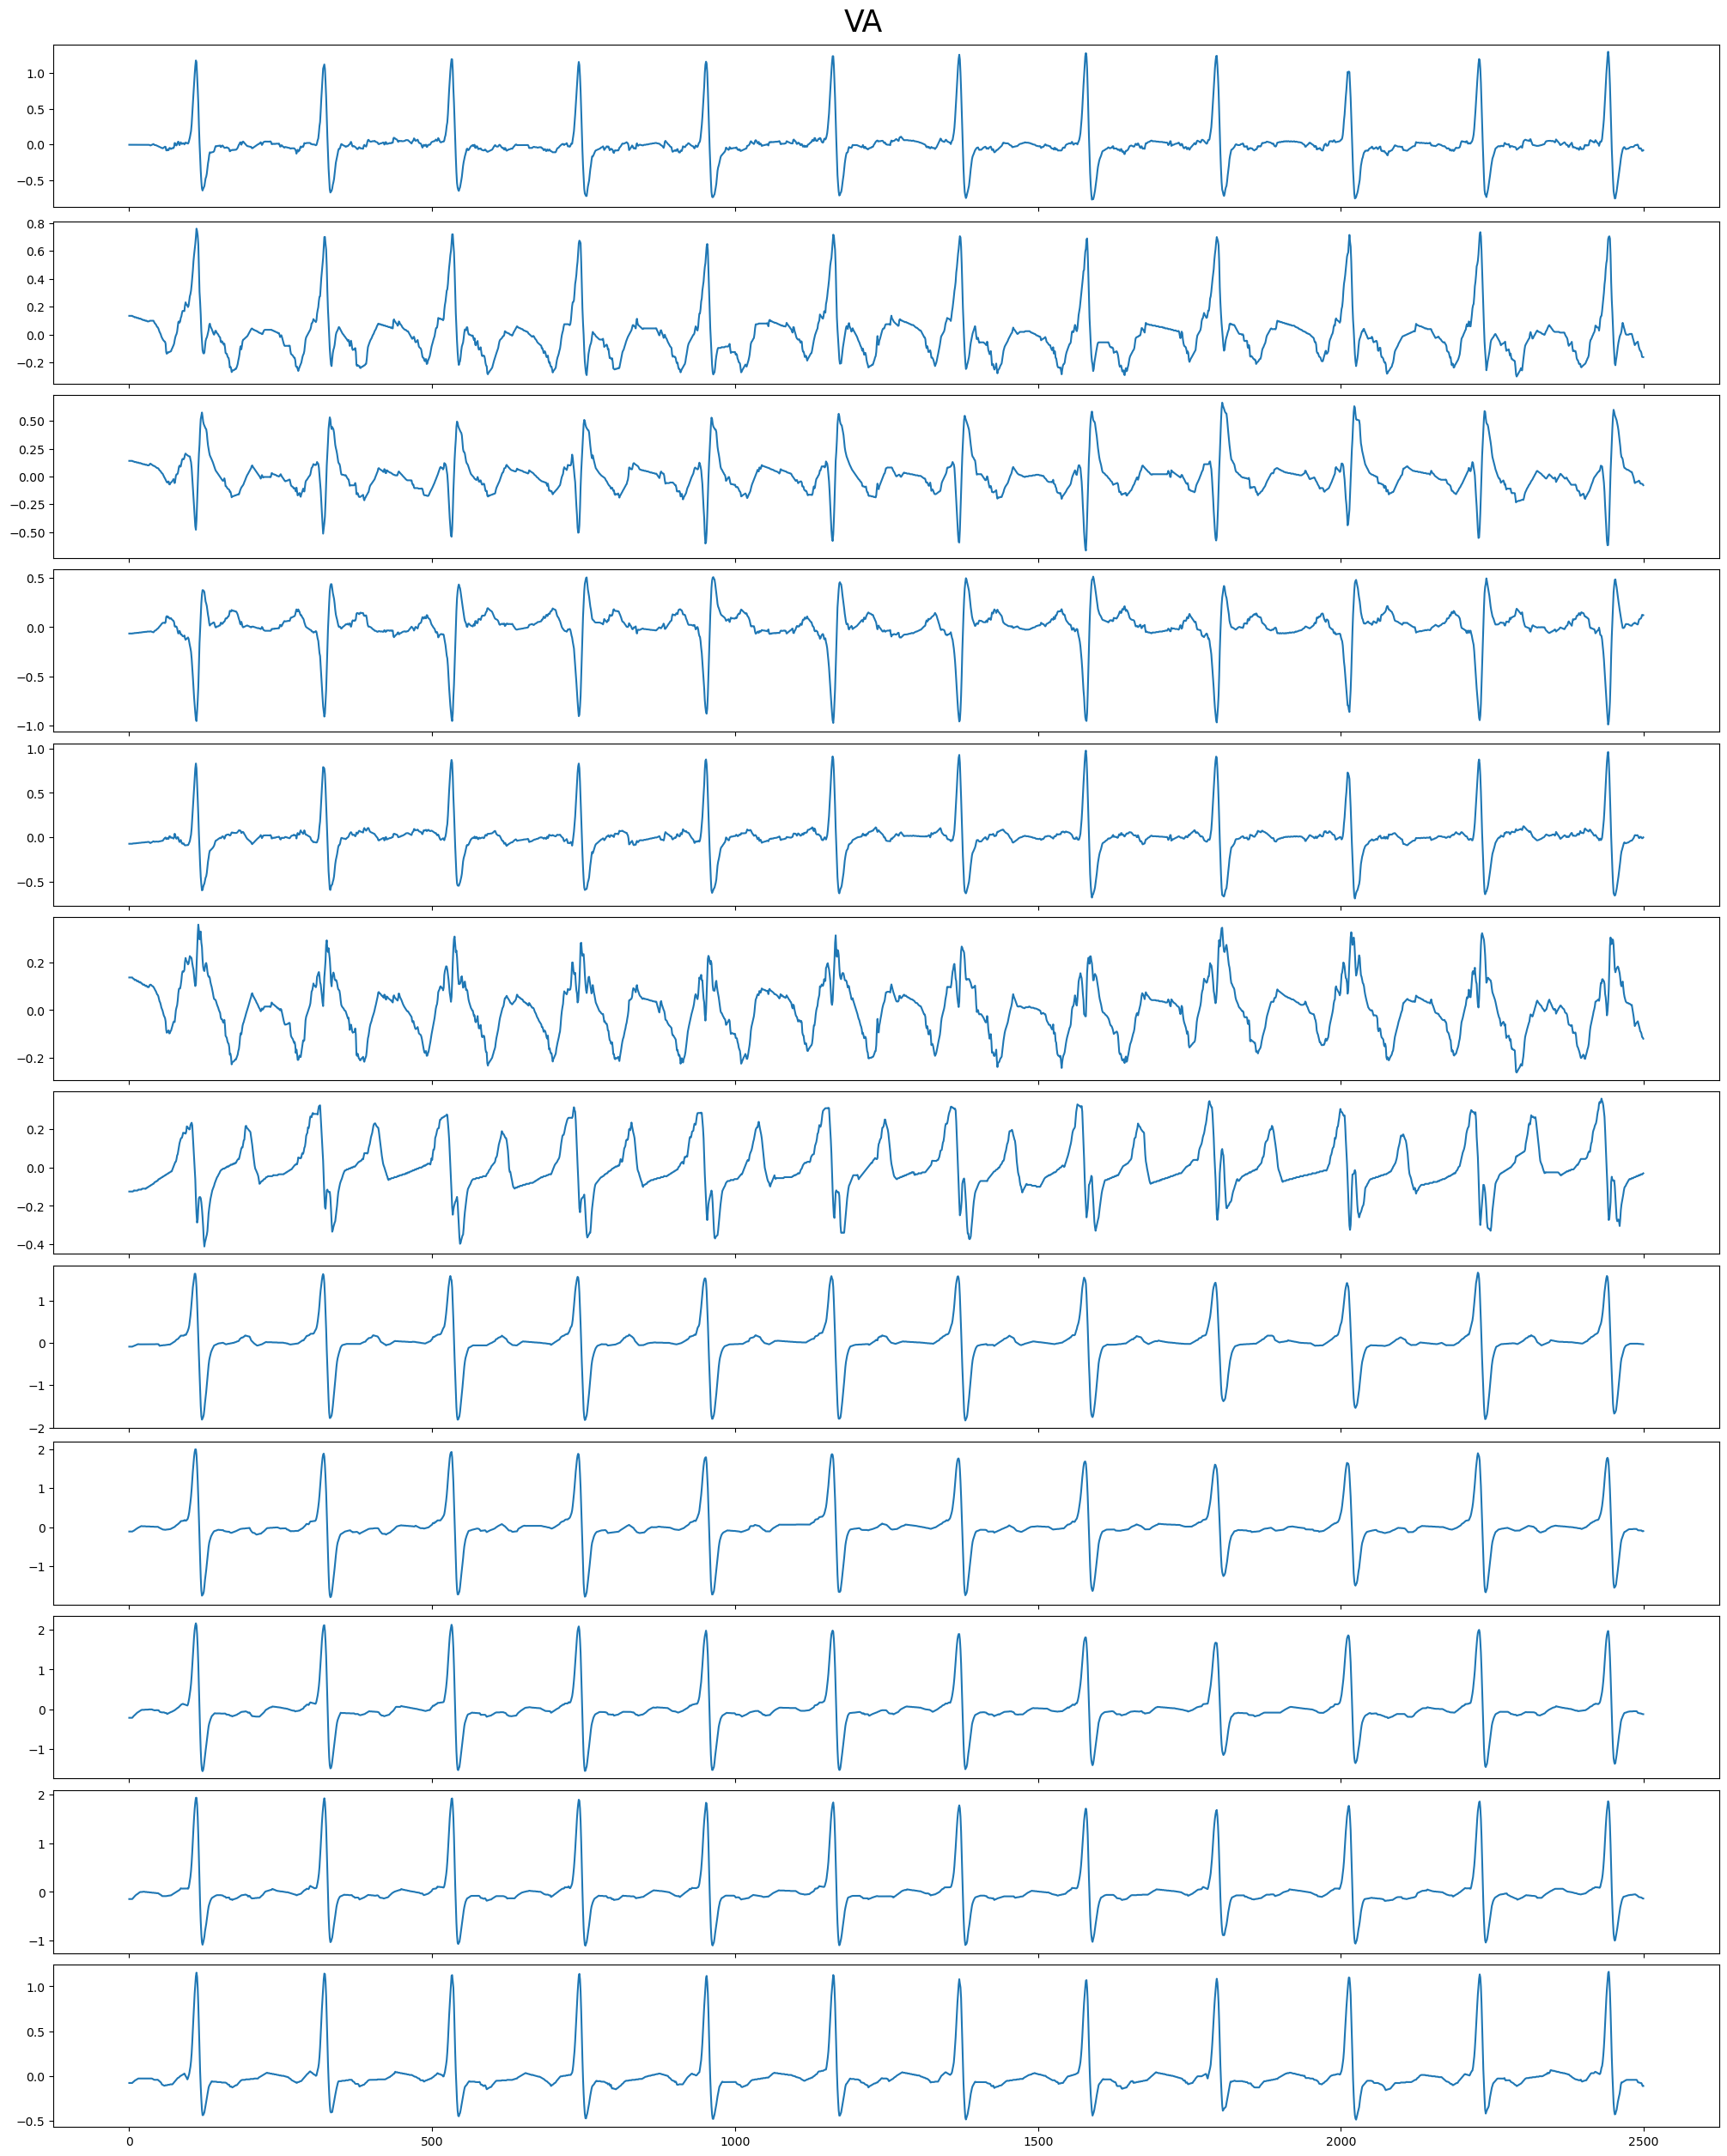

,data,label
0,"[[0.045, 0.045, 0.045, 0.045, 0.046, 0.045, 0....",VA
1,"[[-0.205, -0.205, -0.205, -0.205, -0.205, -0.2...",VA
2,"[[-0.19, -0.19, -0.19, -0.19, -0.19, -0.19, -0...",VA
3,"[[0.005, 0.005, 0.005, 0.004, 0.006, 0.005, -0...",VA
4,"[[-0.225, -0.225, -0.225, -0.225, -0.225, -0.2...",VA
...,...,...
1645,"[[-0.13, -0.13, -0.13, -0.13, -0.13, -0.13, -0...",SR
1646,"[[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.058, 0...",SR
1647,"[[-0.13, -0.13, -0.13, -0.13, -0.13, -0.13, -0...",SR
1648,"[[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0...",SR


In [4]:
# Инициализируем наш алгоритм загрузки данных
ecg.init()





# Создаём датафрейм и настраиваем количество записей каждого из классов
test_ecg = ecg.signal(number_labels = {"SR" : 550, "VA" : 550, "AF" : 550})
"""
Здесь мы создаём датафрейм из графиков ЭКГ каждой записи. 
В параметре 'number_labels' вписывается словарь вида {'Класс недуга' : количество записей по этому классу}.
В нашей задаче выделены три основных класса по записям:
SR - Синусовый ритм, VA - Различные виды аритмии, AF - Фибрилляция предсердия.
 
Желательно, чтобы количество рассматриваемых записей было соизмеримо между классами.
"""




ecg.plot_signal(0) # Строим график первого случайно выбранного элемента для визуализации
test_ecg # Выводим полученный датафрейм, где слева матрица 12 на 2500, представляющая отсчёты 12 отведений записи,
# а справа - класс, присвоенный записи

### Разделение выборки на тренировочную и тестовую и OneHotEncoding 

In [ ]:
# Формируем непосредственно набор данных и меток:
X_ecg = np.array(test_ecg.iloc[:,0].tolist())
y_ecg = np.array(test_ecg.iloc[:,1].tolist())






# И производим деление выборки на тренировочную и тестовую с перемешкой
X_train, X_test, y_train, y_test = train_test_split(X_ecg, y_ecg, test_size = 0.30, shuffle = True)
"""
Здесь можно покрутить параметры разбивки данных на тренировочные и тестовые - настроить процентаж разбвики, например.
"""





# Производим энкодинг полученных меток классов в удобный для обработки сетью вид
print('Метка класса перед энкодингом:', y_train[0])
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
print('Метка класса после энкодинга:', y_train[0])

## Преобразование в новые типы данных

**Здесь будет представлен выбор, в какой из типов данных превратить наши выборки:**
1. Изображение со смещёнными в нём графиками отведений ЭКГ
2. Проекция векторного представления кардиоцикла в записи
3. Представление отведений как спектрограмм, полученых с использованием вейвлетов

### 1. Представление данных как изображений с графиками

In [5]:
# Создаём массив изображений, полученных через наш алгоритм
X_train = np.array([ecg.make_image(record, plot = False) for record in X_train])
X_test = np.array([ecg.make_image(record, plot = False) for record in X_test])

NameError: name 'X_train' is not defined

In [ ]:
plt.imshow(X_train[0]);

In [ ]:
np.unique(X_train[0])

### 2. Представление данных как проекции вектора кардиоцикла

In [6]:
vecg.init(filtering=True, canc_showing=True, plot3D=False)
df_ecg = vecg.make_vecg_df(test_ecg, 0, 1)

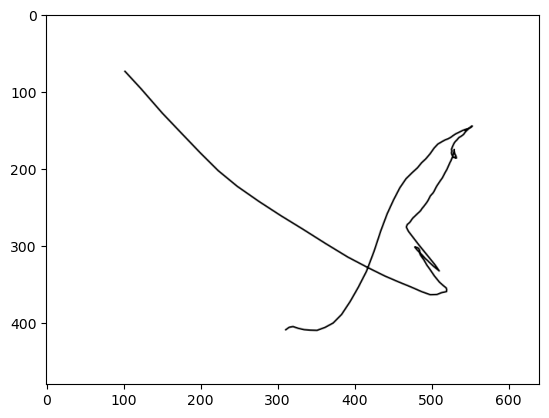

In [7]:
plt.imshow(test_ecg["ZX"][0], cmap = 'gray')

In [8]:
# Формируем непосредственно набор данных и меток:
X_ecg = np.array([test_ecg.iloc[:,2].tolist(),
                 test_ecg.iloc[:,3].tolist(),
                 test_ecg.iloc[:,4].tolist()])
X_ecg = np.transpose(X_ecg, (1, 2, 3, 0))
y_ecg = np.array(test_ecg.iloc[:,1].tolist())

### 3. Представление данных как спектрограмм

In [20]:
wt.init()
time_d, cw_d, freq_d = wt.cwt_transform(test_ecg.iloc[0,0], wt.wavelet()[0])

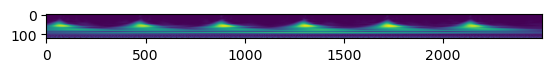

In [26]:
plt.imshow(np.abs(cw_d)[0,:,:])

## Нормировка, разделение выборки на тренировочную и тестовую и OneHotEncoding 

In [9]:
# И производим деление выборки на тренировочную и тестовую с перемешкой
X_train, X_test, y_train, y_test = train_test_split(X_ecg, y_ecg, test_size = 0.30, shuffle = True)
"""
Здесь можно покрутить параметры разбивки данных на тренировочные и тестовые - настроить процентаж разбвики, например.
"""





# Нормируем данные
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# Производим энкодинг полученных меток классов в удобный для обработки сетью вид
print('Метка класса перед энкодингом:', y_train[0])
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
print('Метка класса после энкодинга:', y_train[0])

Метка класса перед энкодингом: VA
Метка класса после энкодинга: [0. 0. 1.]


## Написание класса нейронной сети на основе ResNet18 и её компоновка

***Тут не знаю, что можно поменять, т.к. если менять саму архитектуру, то засесть можем тут надолго. Предложение было сконцентрироваться на одной архитектуре, поэтому советую пока внутренности класса не доставать и не менять :3***

In [10]:
"""
Стандартный блок архитектуры ResNet:
"""

class ResnetBlock(Model):
    
    def __init__(self, channels: int, down_sample=False): # channels: количество каналов = количество ядер свёртки

        super().__init__() # Перенимаем инициализируемые параметры у материнского класса Model

        self.__channels = channels # Задаём количество каналов (ядер свёртки)
        self.__down_sample = down_sample # Задаём параметр, отвечающий за сжатие
        self.__strides = [2, 1] if down_sample else [1, 1] # Задаём шаги ядер при свёртке
        # (в случае down_sample = True, шаг увеличивается в 2 раза и, следовательно, производится сжатие в 2 раза)

        KERNEL_SIZE = (3, 3) # Размер ядра
        INIT_SCHEME = "he_normal" # Закон генерации весов в ядре (здесь нормальный закон)

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Первый слой 2D свёртки
        self.bn_1 = BatchNormalization() # Нормализация значений, полученных на предыдущем слое
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME) # Второй слой 2D свёртки
        self.bn_2 = BatchNormalization()
        self.merge = Add() # Слой поэлементного сложения (пока ничего не складывает, сложение будет дальше)

        if self.__down_sample:
            # Производим сжатие данных в случае down_sample = True
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs # Сохраняем исходные данные
        
        # Производим обработку входных данных по слоям блока:
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out # Выводим результат обработки блоком ResNet входных данных


"""
Непосредственно архитектура ResNet18:
"""

class ResNet18(Model):

    def __init__(self, num_classes, **kwargs): # num_classes: количество классов в решаемой задаче

        super().__init__(**kwargs)
        
        
        # Собираем архитектуру из готовых блоков, созданных нами ранее:
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")
        
    def call(self, inputs):
        
        # Производим обработку входных данных по слоям сети:
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [11]:
model = ResNet18(3)






# Строим модель исходя из заложенного размера объектов
length = X_train.shape[1] # Длина картинки
width = X_train.shape[2] # Ширина картинки
channels = X_train.shape[3] # Количество картинок в одном объекте (число каналов)
model.build(input_shape = (None, length, width, channels))
"""
Если будут какие-то интересные идеи усечения размеров картинок, подаваемых на вход в нейронку,
то предлагаю здесь пошаманить с длиной, шириной и количеством каналов.
"""





# Используем категориальную кроссэнтропию для классов, представленных через one-hot encoding
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) # Оптимизатор, предложенный в источнике
model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()




Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple      

## Обучение нейросети

In [12]:
# Задаём параметры ранней остановки обучения (если валидационная точность перестала улучшаться)
es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")

# Тут задаём параметры обучения сети
batch = 33 # Число объектов, входящих в одну подвыборку
STEPS = len(X_train) / batch # Количество шагов по подвыборкам за эпоху

# Обучение сети:
history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS,
    batch_size = batch,
    epochs = 10,
    validation_data = (X_train, y_train),
    callbacks = [es]
)

Epoch 1/10

35/35 [==============================] - 378s 11s/step - loss: 1.1871 - accuracy: 0.3896 - val_loss: 1006.8474 - val_accuracy: 0.3351
Epoch 2/10
35/35 [==============================] - 352s 10s/step - loss: 1.0502 - accuracy: 0.4433 - val_loss: 2.6770 - val_accuracy: 0.3385
Epoch 3/10
35/35 [==============================] - 348s 10s/step - loss: 1.0138 - accuracy: 0.4961 - val_loss: 1.4544 - val_accuracy: 0.4502
Epoch 4/10
35/35 [==============================] - 354s 10s/step - loss: 0.9697 - accuracy: 0.5264 - val_loss: 7.4591 - val_accuracy: 0.3264
Epoch 5/10
35/35 [==============================] - 357s 10s/step - loss: 0.9156 - accuracy: 0.5662 - val_loss: 11.3564 - val_accuracy: 0.3351
Epoch 6/10
35/35 [==============================] - 355s 10s/step - loss: 0.8177 - accuracy: 0.6346 - val_loss: 43.0935 - val_accuracy: 0.3333
Epoch 7/10
35/35 [==============================] - 356s 10s/step - loss: 0.7176 - accuracy: 0.6874 - val_loss: 48.7782 - val_accuracy: 0.3325

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


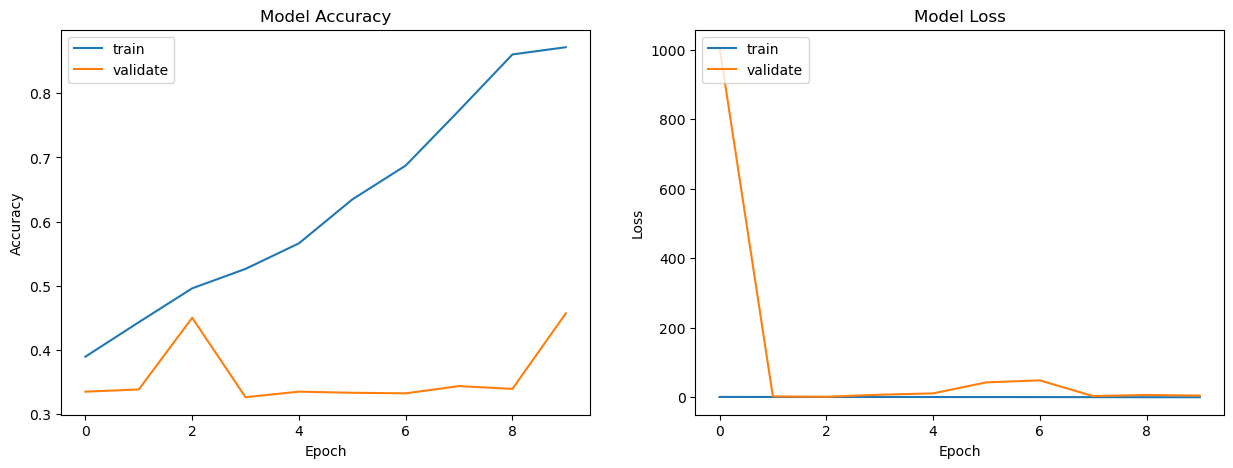

In [15]:
def plotmodelhistory(history): 
    
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    
    plt.show()

print(history.history.keys())
plotmodelhistory(history)

In [16]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

16/16 [==============================] - 25s 2s/step - loss: 6.8210 - accuracy: 0.3980
Model Loss is 6.821030616760254
Model Accuracy is 0.3979797959327698
